## Test OPTICS: Paper Figure (multi-test)

In [1]:
import os, glob, getpass, sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack, hstack, Column, MaskedColumn, unique
from astropy.utils.exceptions import AstropyWarning

user = getpass.getuser()
sys.path.append('/Users/' + user + '/Dropbox/my_python_packages')
path = '../../'
from pyclustering.cluster.optics import optics, ordering_analyser

In [2]:
def set_plot(ftsize, title, xlim = [-10,2500], ylim = [0.15,1.5], xstick_step = 500, showlegend = True, 
          showylabel = True, handlelength = 0.5, showgrid = True):
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel('Point', fontsize = ftsize)
    if showylabel:
        plt.ylabel(r'Reachability Distance', fontsize = ftsize)
    plt.xticks(np.arange(np.min(xlim)+10, np.max(xlim)+1, xstick_step), fontsize = ftsize)
    plt.yticks(fontsize = ftsize)
    if showlegend:
        plt.legend(loc = 'lower right', fontsize = ftsize*0.8, handlelength = handlelength)
    plt.grid()
    plt.title(title, fontsize = ftsize)

In [3]:
# Read data ====================================
warnings.simplefilter('ignore', AstropyWarning)
data     = Table.read(path + 'sample_gaia/gaia_sample_cleaned.vot',       format = 'votable')
control  = Table.read(path + 'sample_control/OPH___control_sample.vot',   format = 'votable') ; control.label = 'Control'
data_scl = Table.read(path + 'sample_clusters/cl_scale/scl_standard.vot', format = 'votable')

# Optics data preparison ======================= 
data_scl = data_scl.to_pandas().values

In [4]:
# Compute dataset ordering =============================
eps_0   = 2.0                   # Zero-Point EPS: starting value.
mpts_s  = [14,   16    , 18]    # mPts listed on the paper.
eps_s   = [0.245, 0.259, 0.265] # Inferred EPSs for previous mptss
orders  = []

# Compute Sorted k-distance plot =====
for i in range(len(mpts_s)):
    model = optics(data_scl, eps_0, mpts_s[i], ccore=False) #ccore=False to make it work in MacOs !!
    model.process()
    orders.append(ordering_analyser(model.get_ordering()))

In [5]:
# Extract Main cluster =================
cl_main = []
cl_len  = []

for i in range(len(mpts_s)):
    model_f      = optics(data_scl, eps_s[i], mpts_s[i], ccore=False) #ccore=False to make it work in MacOs !!
    model_f.process()
    clusters     = model_f.get_clusters()
    clusters_els = [len(inp) for inp in clusters]
    cluster_out  = data[clusters[np.argmax(clusters_els)]]
    cl_main.append(cluster_out)
    cl_len.append(len(cluster_out))
    cluster_out.write('cl_optics_mpts_' + np.str(mpts_s[i]) + '.vot', format = 'votable', overwrite = True)    

In [6]:
# Create Table to quickly inspect the outputs ====
# This is a security check ===
output = Table(data = [['OPTICS'] *len(mpts_s)] + [mpts_s, eps_s, cl_len], names = ['Algorithm', 'mPts', 'Eps', 'Elements'])
output.write('output_optics.tex', format = 'ascii.latex', overwrite = True)

output

Algorithm,mPts,Eps,Elements
str6,int64,float64,int64
OPTICS,14,0.245,451
OPTICS,16,0.259,494
OPTICS,18,0.265,497


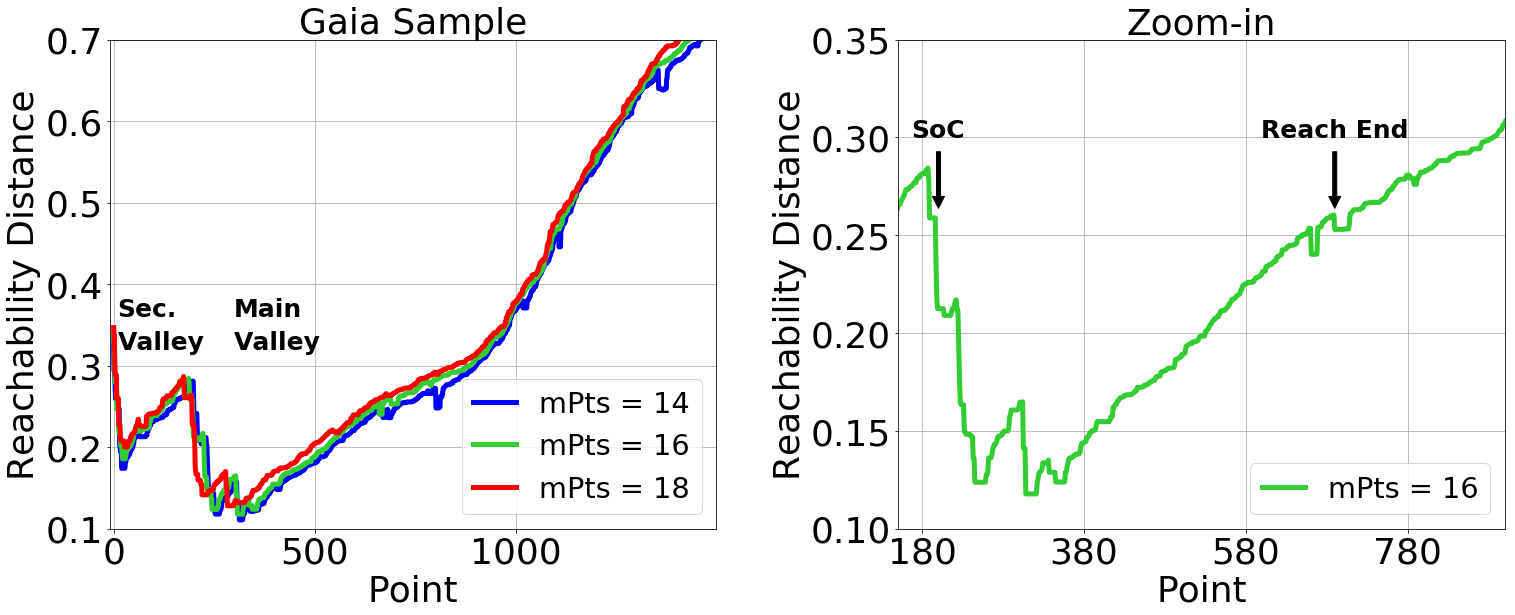

In [7]:
# Make Plot ============================================
fig       = plt.figure(figsize=[25,9])
ftsize    = 36
linewidth = 5
colors    = ['blue', 'limegreen', 'red']

#===============
plt.subplots_adjust(wspace = 0.3)
plt.subplot(121)
index  = -1
ylim   = [0.1, 0.7]
for order in orders:
    index = index+1
    plt.plot(order.cluster_ordering, label = 'mPts = ' + np.str(mpts_s[index]), linewidth = linewidth, color = colors[index])
pp = set_plot(ftsize, title='Gaia Sample', ylim = ylim, xlim=[-10,1499], xstick_step=500, handlelength = 1.5)

plt.annotate('Sec.',   xy=(10,0.36), fontsize = 25, weight="bold")
plt.annotate('Valley', xy=(10,0.32), fontsize = 25, weight="bold")

plt.annotate('Main',   xy=(300,0.36), fontsize = 25, weight="bold")
plt.annotate('Valley', xy=(300,0.32), fontsize = 25, weight="bold")

#===============
ax   = plt.subplot(122)
i    = 1
ylim = [0.10, 0.35]
xlim = [150, 900]
plt.plot(orders[i].cluster_ordering, '-', color = colors[i], label = 'mPts = ' + str(mpts_s[i]), linewidth = linewidth)
pp = set_plot(ftsize, title='Zoom-in', ylim = ylim, xlim=xlim, xstick_step=200, 
           showlegend=True, showylabel=True, handlelength = 1.5)

plt.yticks(np.arange(np.min(ylim),    np.max(ylim) + 0.001, 0.05), fontsize = ftsize)
plt.xticks(np.arange(np.min(xlim)+30, np.max(xlim), 200),          fontsize = ftsize)


ax.annotate('SoC', xy=(200, 0.26), xytext=(200, 0.30), ha="center", fontsize = 25, weight = 'bold', arrowprops=dict(facecolor='black', shrink=0.1))
ax.annotate('Reach End',        xy=(690, 0.26), xytext=(690, 0.30), ha="center", fontsize = 25, weight = 'bold', arrowprops=dict(facecolor='black', shrink=0.1))
# ax.axhline(xmin=0, xmax=1000, y=0.259, linestyle= ':', color = 'black')


plt.show()
fig.savefig('02_run_optics_0.pdf',bbox_inches = 'tight', overwrite = True)